In [1]:
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
from datasets import MixedImgDataset


In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
dataset = MixedImgDataset(root_dir='./data/MixedImg', transform=transform)

# Check dataset
print(f"Dataset size: {len(dataset)}")
print(f"Classes: {dataset.classes}")
print(f"Class to index mapping: {dataset.class_to_idx}")

Dataset size: 42
Classes: ['Disturbance', 'IF', 'Normal']
Class to index mapping: {'Disturbance': 0, 'IF': 1, 'Normal': 2}


In [3]:
from torch.utils.data import random_split
batch_size = 4
# Define split ratio (e.g., 80% training, 20% testing)
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate lengths
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create separate dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print information about the splits
print(f"Total dataset size: {dataset_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Total dataset size: 42
Training set size: 33
Testing set size: 9


In [4]:
from models import BYOL
from torch import nn

base_net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 3),
    )

image_size = 224
model = BYOL(net=base_net, image_size=image_size)

Using device: mps
Starting training...


Epoch 1/10: 100%|██████████| 9/9 [00:26<00:00,  2.90s/it, Loss=2.98]


Epoch 1/10, Loss: 3.1259


Epoch 2/10: 100%|██████████| 9/9 [00:22<00:00,  2.49s/it, Loss=1.82]


Epoch 2/10, Loss: 1.5807


Epoch 3/10: 100%|██████████| 9/9 [00:22<00:00,  2.51s/it, Loss=1.19] 


Epoch 3/10, Loss: 0.9461


Epoch 4/10: 100%|██████████| 9/9 [00:22<00:00,  2.48s/it, Loss=0.658]


Epoch 4/10, Loss: 0.6529


Epoch 5/10: 100%|██████████| 9/9 [00:22<00:00,  2.47s/it, Loss=0.79] 


Epoch 5/10, Loss: 0.5343


Epoch 6/10: 100%|██████████| 9/9 [00:22<00:00,  2.51s/it, Loss=0.606]


Epoch 6/10, Loss: 0.4848


Epoch 7/10: 100%|██████████| 9/9 [00:22<00:00,  2.48s/it, Loss=0.74] 


Epoch 7/10, Loss: 0.3516


Epoch 8/10: 100%|██████████| 9/9 [00:22<00:00,  2.45s/it, Loss=0.343]


Epoch 8/10, Loss: 0.3671


Epoch 9/10: 100%|██████████| 9/9 [00:22<00:00,  2.51s/it, Loss=0.422]


Epoch 9/10, Loss: 0.3757


Epoch 10/10: 100%|██████████| 9/9 [00:22<00:00,  2.46s/it, Loss=0.211]

Epoch 10/10, Loss: 0.3441
Training completed in 227.33 seconds


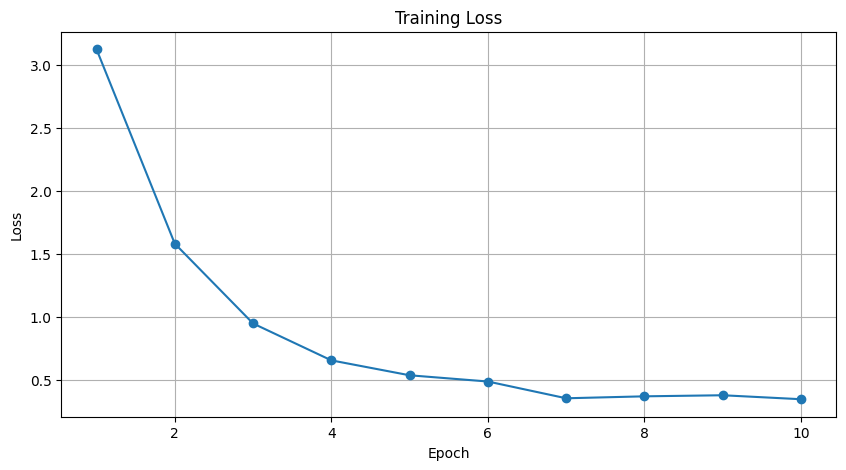

Model saved!


In [5]:
import torch
from tqdm import tqdm
import time

import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Set training parameters
num_epochs = 10
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Track metrics
train_losses = []

# Training loop
print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (images, _) in enumerate(progress_bar):
        # Skip batches that are too small (happens at the end sometimes)
        if images.size(0) < 2:
            continue
        # Move images to device
        images = images.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass and compute loss
        loss = model(images)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})
    
    # Calculate average loss
    avg_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

total_time = time.time() - start_time
print(f"Training completed in {total_time:.2f} seconds")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Save the model
torch.save(model.state_dict(), 'byol_model.pth')
print("Model saved!")

Testing the model...
Accuracy: 0.5556
Recall: 0.5556
F1 Score: 0.3968

Classification Report:
              precision    recall  f1-score   support

 Disturbance       0.00      0.00      0.00         1
          IF       0.00      0.00      0.00         3
      Normal       0.56      1.00      0.71         5

    accuracy                           0.56         9
   macro avg       0.19      0.33      0.24         9
weighted avg       0.31      0.56      0.40         9



/opt/homebrew/Caskroom/miniforge/base/envs/PyTc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/PyTc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/PyTc/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

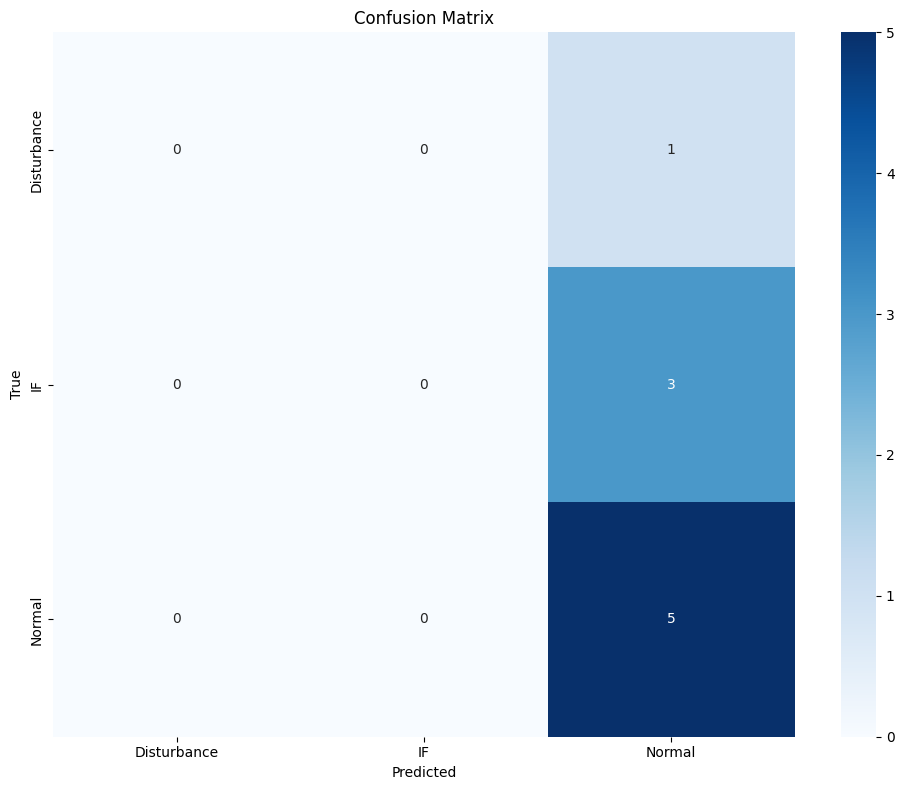

In [6]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Test the model's performance
model.eval()
all_preds = []
all_labels = []

print("Testing the model...")

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        
        # Extract features using the online encoder
        features = model.online_encoder.net(images)
        
        # Since we're using BYOL (a self-supervised model), we need to make predictions
        # This is a simplified approach - in practice, you might want to train a classifier on top of the features
        # For demonstration, we'll use the output dimensionality to make predictions
        preds = torch.argmax(features, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics

accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Plot confusion matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dataset.classes, 
            yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()